In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from torch.utils.data import ConcatDataset
from PIL import Image
import os
import torchvision.models as models
import time
import copy
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from feature_extraction import feature_extraction, sample_images

from dataloading import load_data


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

transform = transforms.Compose([ 
    transforms.Resize((227, 227)),  
    transforms.ToTensor()
])    

data_percentage = 5


train_loader, _, classes = load_data(data_dir = '../data/vegetable_images',
                           batch_size = 64,
                           data_type = "train",
                           noise_type = "None",
                           noise_percentage = 0,                           
                           transform = transform,                           
                           data_percentage=data_percentage)

valid_loader, _, _ = load_data(data_dir = '../data/vegetable_images',
                           batch_size = 64,
                           data_type = "validation",
                           noise_type = "None",
                           noise_percentage = 0,                           
                           transform = transform,                           
                           data_percentage=data_percentage)

test_loader, _, _ = load_data(data_dir = '../data/vegetable_images',
                           batch_size = 64,
                           data_type = "test",
                           noise_type = "None",
                           noise_percentage = 0,                           
                           transform = transform,                           
                           data_percentage=data_percentage)


path:  ../data/vegetable_images/train
needed_length: 750, expected_length_per_class: 50
length of final dataset: 750
path:  ../data/vegetable_images/validation
needed_length: 150, expected_length_per_class: 10
length of final dataset: 150
path:  ../data/vegetable_images/test
needed_length: 150, expected_length_per_class: 10
length of final dataset: 150


In [19]:
test_loader_with_noise, _, _ = load_data(data_dir = '../data/vegetable_images',
                           batch_size = 64,
                           data_type = "test",
                           noise_type = "gaussian_noise",
                           noise_percentage = 100,                           
                           transform = transform,                           
                           data_percentage=data_percentage)

path:  ../data/vegetable_images/gaussian_noise/test/100
needed_length: 150, expected_length_per_class: 10
length of final dataset: 150


In [4]:

concat_dataset = ConcatDataset([train_loader.dataset, valid_loader.dataset, test_loader.dataset])

# Create a new data loader from the concatenated dataset
batch_size = 64  # Set your desired batch size
concat_loader = DataLoader(concat_dataset, batch_size=batch_size, shuffle=True)

In [4]:
total = []
for images, _ in train_loader:
    images, _ = next(iter(concat_loader))
    flattened_image = images.view(images.size(0), images.size(1), -1)
    total.append(flattened_image)
pixel_values = torch.cat(total, dim=0)
pixel_values.shape



torch.Size([7552, 3, 51529])

In [5]:
mean = torch.mean(pixel_values, dim=0)
mean.shape

torch.Size([3, 51529])

In [6]:
mean_per_channel = mean.mean(dim=1)
mean_per_channel

tensor([0.4691, 0.4631, 0.3419])

In [7]:
std = torch.std(pixel_values, dim=0)


In [8]:
std_sq = torch.square(std)
std_mean = std_sq.mean(dim = 1)
std_mean

tensor([0.0539, 0.0516, 0.0573])

In [9]:
std_mean = torch.sqrt(std_mean)
std_mean

tensor([0.2322, 0.2272, 0.2394])

# Feature Extraction Analysis 

In [6]:
image, label = next(iter(concat_loader))

In [7]:
label

tensor([ 7,  8, 14, 13,  0,  8, 10,  9, 10,  5, 10,  6,  8, 11, 10, 13, 10,  7,
         5,  0, 12,  7,  1,  9, 11, 10, 12, 13, 10,  3, 11,  4,  7, 11, 12,  7,
        11,  5,  8, 11,  0,  7,  9,  8,  8,  9,  7, 10,  8,  2,  8,  5, 12,  2,
         9,  9,  8, 13,  4, 13, 13,  1,  6,  8])

In [21]:
import random

class_images = {}

for batch in test_loader:
    images, labels = batch

    for image, label in zip(images, labels):
        if label.item() not in class_images:
            class_images[label.item()] = []
        class_images[label.item()].append(image)
for class_label in class_images:
    if len(class_images[class_label]) < 10:
        raise ValueError(f"Class {class_label} does not have enough images.")

sampled_images = {}
for class_label in class_images:
    sampled_images[class_label] = random.sample(class_images[class_label], 10)


In [11]:
sampled_images = sample_images(test_loader, 10)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2744\1275619530.py:9: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  df,_ = feature_extraction(image)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2744\1275619530.py:9: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  df,_ = feature_extraction(image)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2744\1275619530.py:9: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  df,_ = feature_extraction(image)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2744\1275619530.py:9: UserWarning: Possible precision loss converting image of type float32 to uint8 as

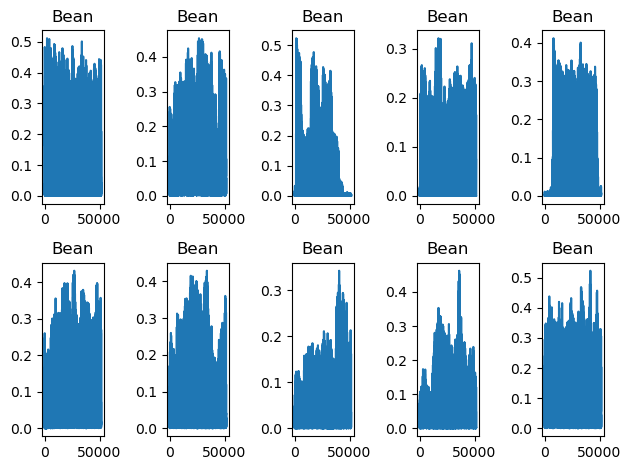

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=2, ncols=5)

# Step 4: Iterate over subplots and plot data
count = 0
for i, ax in enumerate(axs.flatten()):
    image = sampled_images[0][count]
    df,_ = feature_extraction(image)
    ax.plot(df.index, df['Sobel'])
    ax.set_title(classes[0])
    count+=1

# Step 5: Adjust layout and display plot
plt.tight_layout()
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2744\1997977639.py:10: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  df,_ = feature_extraction(image)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2744\1997977639.py:10: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  df,_ = feature_extraction(image)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2744\1997977639.py:10: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  df,_ = feature_extraction(image)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_2744\1997977639.py:10: UserWarning: Possible precision loss converting image of type float32 to uint

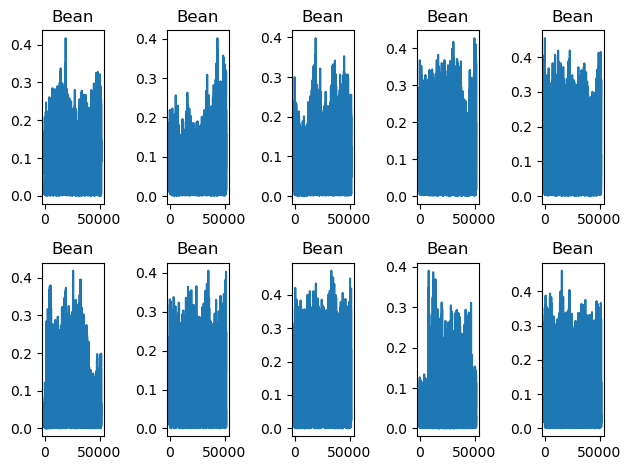

In [20]:
sampled_images = sample_images(test_loader_with_noise, 10)


fig, axs = plt.subplots(nrows=2, ncols=5)

# Step 4: Iterate over subplots and plot data
count = 0
for i, ax in enumerate(axs.flatten()):
    image = sampled_images[0][count]
    df,images = feature_extraction(image)
    ax.plot(df.index, df['Sobel'])
    ax.set_title(classes[0])
    count+=1

# Step 5: Adjust layout and display plot
plt.tight_layout()
plt.show()